# 6. ML-ENSO - CLASSIFICATION

In [1]:
print("hello world")

hello world


In [2]:
import utils

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator

import os
import pandas as pd
import xarray as xr
import calendar
import pickle

from datetime import datetime

import sklearn
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import scipy.stats

from tqdm import tqdm

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.metrics import f1_score



### Define folders

In [4]:
# CMIP6_ANOM_1M_FOLDER = 'datasets/CMIP6/CMIP6_regridded/anom_1m'
# CMIP6_ONI_FOLDER = 'datasets/CMIP6/CMIP6_regridded/oni'
# CMIP6_NINO34_FOLDER = 'datasets/CMIP6/CMIP6_regridded/nino34'

# HadISST_ANOM_1M_FOLDER = 'datasets/HadISST/HadISST_regridded/anom_1m'
# HadISST_ONI_FOLDER = 'datasets/HadISST/HadISST_regridded/oni'
# HadISST_NINO34_FOLDER = 'datasets/HadISST/HadISST_regridded/nino34'

MODELS_ONI_FOLDER = 'saved_models/oni'
MODELS_NINO34_FOLDER = 'saved_models/nino34'

RESULTS_ONI_FOLDER = 'saved_results/oni'
RESULTS_NINO34_FOLDER = 'saved_results/nino34'
RESULTS_EC_FOLDER = 'saved_results/ec'

RESULTS_EC_PF_FOLDER = os.path.join(RESULTS_EC_FOLDER, "persistent_forecast")
RESULTS_EC_LR_FOLDER = os.path.join(RESULTS_EC_FOLDER, "linear_regression")
RESULTS_EC_RR_FOLDER = os.path.join(RESULTS_EC_FOLDER, "ridge_regression")

os.makedirs(RESULTS_EC_PF_FOLDER, exist_ok=True) 
os.makedirs(RESULTS_EC_LR_FOLDER, exist_ok=True) 
os.makedirs(RESULTS_EC_RR_FOLDER, exist_ok=True) 

IMG_FOLDER = 'img/'
SAVE_PLOTS_TO_DISK = False

In [5]:
CMIP6_ANOM_1M_FOLDER = 'datasets/CMIP6/CMIP6_regridded/anom_1m'
HadISST_ANOM_1M_FOLDER = 'datasets/HadISST/HadISST_regridded/anom_1m'

In [6]:
CMIP6_EC_FOLDER = 'datasets/CMIP6/CMIP6_regridded/ec_indices'
HadISST_EC_FOLDER = 'datasets/HadISST/HadISST_regridded/ec_indices'

### Global variables

In [7]:
# full map
# MIN_LAT, MAX_LAT = -90, +90
# MIN_LON, MAX_LON = 0, 360
# LAT_SLICE = None
# LON_SLICE = None

# Ham et. al: 0°–360°E, 55°S–60°N
MIN_LAT, MAX_LAT = -55, 60
MIN_LON, MAX_LON = 0, 360
LAT_SLICE = slice(MIN_LAT, MAX_LAT)
LON_SLICE = slice(MIN_LON, MAX_LON)


In [8]:
# source_id = "MRI-ESM2-0"
# source_id = "MIROC6"
# source_id = "BCC-ESM1"
source_id = "GISS-E2-1-G"

# MAX_LEAD_TIME = 49
MAX_LEAD_TIME = 13
INPUT_TIME_STEPS = 1

### Split Train / Val / Test sets longitudinally
Randomly splitting time series data into a train set and a test set is very risky. \
In many climate datasets, time series have a non-neglible auto-correlation (correlation of a time series and its lagged version over time). \
Think of it like this: the atmosphere usually has a "memory" of about 14 days, and the ocean roughly has a "memory" of about 2 years.

_(source: [CCAI Seasonal Forecasting tutorial](https://colab.research.google.com/drive/1eLEYFK3Mrae_nu1SzAjg7Sdf40bWnKTg#scrollTo=XrbMcDoscZM0&forceEdit=true&sandboxMode=true))_

In [9]:
# dates for observational dataset HadISST (1870-01-16 to 2024-02-15)
# train_start_date = '1871-01-01'
# train_end_date = '1970-12-31'

# val_start_date = '1976-01-01'
# val_end_date =   '1990-12-31'

# test_start_date = '1996-01-01'
# test_end_date =   '2020-12-31'

In [10]:
train_start_date = '1851-01-01'
train_end_date = '1970-12-31'

val_start_date = '1976-01-01'
val_end_date =   '1990-12-31'

test_start_date = '1996-01-01'
test_end_date =   '2010-12-31'

print(f"Train start and end dates: {train_start_date} to {train_end_date}")
print(f"Val start and end dates: {val_start_date} to {val_end_date}")
print(f"Test start and end dates: {test_start_date} to {test_end_date}")

Train start and end dates: 1851-01-01 to 1970-12-31
Val start and end dates: 1976-01-01 to 1990-12-31
Test start and end dates: 1996-01-01 to 2010-12-31


In [11]:
# extract year part of the dates
train_start_year = train_start_date.split("-")[0]
train_end_year   = train_end_date.split("-")[0]

val_start_year = val_start_date.split("-")[0]
val_end_year   = val_end_date.split("-")[0]

test_start_year = test_start_date.split("-")[0]
test_end_year   = test_end_date.split("-")[0]

print(f"Train start and end years: {train_start_year}-{train_end_year}")
print(f"Val start and end years: {val_start_year}-{val_end_year}")
print(f"Test start and end years: {test_start_year}-{test_end_year}")

Train start and end years: 1851-1970
Val start and end years: 1976-1990
Test start and end years: 1996-2010


## Define Functions

#### `find_file`

In [12]:
def find_file(directory, source_id):
    filenames = os.listdir(directory)

    # Iterate over files int the directory and return the first match
    for filename in filenames:
        if source_id in filename:
            filepath = os.path.join(directory, filename)
            return filename, filepath
    print(f"No file with source id {source_id} was found")
    return None 

In [13]:
# test function
find_file(CMIP6_ANOM_1M_FOLDER, "BCC-ESM1")

('CMIP.BCC.BCC-ESM1.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nc',
 'datasets/CMIP6/CMIP6_regridded/anom_1m/CMIP.BCC.BCC-ESM1.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nc')

In [14]:
# # Wrapper Function for Printing - checks the verbosity level before printing - Generated with ChatGPT4
# def verbose_print(level, message, verbose):
#     if verbose >= level:
#         print(message)

#### `plot_nino_time_series`

In [15]:
def plot_nino_time_series(y, predictions, source_id, title):
    """
    inputs
    ------
        y           pd.Series : time series of the true Nino index
        predictions np.array  : time series of the predicted Nino index (same
                                length and time as y)
        titile                : the title of the plot

    outputs
    -------
        None.  Displays the plot
    """
    predictions = pd.Series(predictions, index=y.index)
    predictions = predictions.sort_index()
    y = y.sort_index()
    
    plt.figure(figsize=(6,1))  # Set the size of the figure
    
    plt.plot(y, label=f'GT ({source_id})')
    plt.plot(predictions, '--', label='ML Predictions')
    # plt.legend(loc='best', fontsize=7)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=7)

    plt.title(title, fontsize=8)
    plt.ylabel('ONI')
    # plt.xlabel('Date')
    plt.show()
    plt.close()

#### `plot_strong_event_time_series`

In [16]:
def plot_strong_event_time_series(y, predictions, source_id, title):
    """
    inputs
    ------
        y           pd.Series : time series of the true E or C class
        predictions np.array  : time series of the predicted E or C class (same
                                length and time as y)
        titile                : the title of the plot

    outputs
    -------
        None.  Displays the plot
    """
    predictions = pd.Series(predictions, index=y.index)
    predictions = predictions.sort_index()
    y = y.sort_index()
    
    plt.figure(figsize=(10,1.5))  # Set the size of the figure
    
    plt.plot(y, label=f'GT ({source_id})')
    plt.plot(predictions, '--', label='ML Predictions')
    plt.legend(loc='best', fontsize=7)
    # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=7)

    plt.title(title, fontsize=9)
    plt.ylabel('Strong Event')
    # Set y-ticks to only 0 and 1
    plt.yticks([0, 1])
    # plt.xlabel('Date')
    plt.grid(linestyle='dashed')
    plt.show()
    plt.close()

#### `assemble_predictors_predictands`
This function was inspired by CCAI AI for Climate science - Forecasting the El Niño with Machine Learning

In [17]:
def assemble_basic_predictors_predictands(source_id, target, start_date, end_date, lead_time,  lat_slice=None, lon_slice=None, verbose=False):
    """
    (inspired by CCAI AI for Climate science workshop - Forecasting the El Niño with Machine Learning)
    
    inputs
    ------
      source_id         str : the source_id of the dataset to load
      start_date        str : the start date from which to extract sst
      end_date          str : the end date
      lead_time         int : the number of months between each sst
                              values and the target Index 
    
    outputs
    -------
      Returns a tuple of the predictors (np array of sst temperature anomalies)
      and the predictands (np array of the ONI index at the specified lead time).
    
    """

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    #### SST VALUES ####
    if source_id == 'HADISST':
        sst_filename, sst_filepath = find_file(HadISST_ANOM_1M_FOLDER, source_id)
    else:
        sst_filename, sst_filepath = find_file(CMIP6_ANOM_1M_FOLDER, source_id)
        
        
        
    ds = xr.open_dataset(sst_filepath)

    # Squeeze out dimensions of size one, if any (e.g. member_id, dcpp_init_year)
    squeezed_ds = ds.squeeze()

    # select sst anomalies for the required time period
    sst_anom = squeezed_ds["tos_anom_1m"].sel(time=slice(start_date, end_date))

    if lat_slice is not None:
        sst_anom = sst_anom.sel(lat=lat_slice)
    
    if lon_slice is not None:
        sst_anom = sst_anom.sel(lon=lon_slice)
        
    num_time_steps = sst_anom.coords['time'].size
    
    # reshape sst_anom into a 2D array: (time_steps, lat*lon)
    sst_anom = sst_anom.values.reshape(num_time_steps, -1)
        
    # replace nan values with 0
    nb_nan_entries = np.count_nonzero(np.isnan(sst_anom))
    total_nb_entries = num_time_steps*sst_anom.shape[1]
    sst_anom[np.isnan(sst_anom)] = 0


    if verbose: 
        print(f"• Load {sst_filename}", end=" ")
        print(f"({ds['time'][0].values.astype('datetime64[D]')} to {ds['time'][-1].values.astype('datetime64[D]')})")
        print(f"• Slice the time period from {start_date.date()} to {end_date.date()}")
        print(f"• Reshape sst anomalies into a 2D {sst_anom.shape} array: {num_time_steps} months x {sst_anom.shape[1]} lat*long values per month")
        print(f"• Replace {nb_nan_entries:,} nan values (continents) out of {total_nb_entries:,} with 0's ({nb_nan_entries/total_nb_entries:.2%})")
        print(f"• The dimensions are: {sst_anom.shape}: {sst_anom.shape[0]} months, {sst_anom.shape[1]} lat*long values per month")


    ds.close()
    squeezed_ds.close()


    if source_id == 'HADISST':
        target_folder = HadISST_EC_FOLDER
    else:
        target_folder = CMIP6_EC_FOLDER

    #### TARGET VALUES ####
    if target == "E_strong":
        target_var_name = 'E_strong'
    elif target == "C_strong":
        target_var_name = 'C_strong'
    elif target == "E":
        target_var_name = 'E'
    elif target == "C":
        target_var_name = 'C'
    else:
        print(f"Unknown target {target}. Abort")
        return

    target_filename, target_filepath = find_file(target_folder, source_id)

    df = pd.read_csv(target_filepath, sep='\t', index_col=0) 
    df.index = pd.to_datetime(df.index)

    target_ts = df[target_var_name]
    
    date_offset = pd.DateOffset(months=lead_time)
    start_date_plus_lead = start_date + date_offset
    end_date_plus_lead = end_date + date_offset
    
    target_ts = target_ts[start_date_plus_lead:end_date_plus_lead]

    if verbose: 
        print(f"\n• Search for `{source_id}` target file in {target_folder}")
        print(f"• Load {target_filename}", end=" ")
        print(f"({df.index[0].date()} to {df.index[-1].date()})")
        print(f"• Slice the time period with {lead_time} month(s) lead time: from {start_date_plus_lead.date()} to {end_date_plus_lead.date()}")
        print(f"• The dimensions are: {target_ts.shape}: {target_ts.shape[0]} months, 1 target value per month\n")
        
    # if verbose: 
    #     # print(f"\n• Search for `{source_id}` ONI file in {CMIP6_ONI_FOLDER}")
    #     print(f"\n• Load {oni_filename}")
    #     print(f"({df.index[0].date()} to {df.index[-1].date()})")
    #     print(f"• Slice the time period with {lead_time} month(s) lead time: from {start_date_plus_lead.date()} to {end_date_plus_lead.date()}")
    #     print(f"• The dimensions are: {oni_ts.shape}: {oni_ts.shape[0]} months, 1 oni value per month")

    return sst_anom.astype(np.float32), target_ts.astype(np.float32)

In [18]:
# example
target = 'E_strong'
X_train, y_train = assemble_basic_predictors_predictands("BCC-ESM1", target, train_start_date, train_end_date, lead_time=1,  lat_slice=LAT_SLICE, lon_slice=LON_SLICE, verbose=True)

• Load CMIP.BCC.BCC-ESM1.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nc (1850-01-16 to 2014-12-16)
• Slice the time period from 1851-01-01 to 1970-12-31
• Reshape sst anomalies into a 2D (1440, 41400) array: 1440 months x 41400 lat*long values per month
• Replace 18,331,200 nan values (continents) out of 59,616,000 with 0's (30.75%)
• The dimensions are: (1440, 41400): 1440 months, 41400 lat*long values per month

• Search for `BCC-ESM1` target file in datasets/CMIP6/CMIP6_regridded/ec_indices
• Load CMIP.BCC.BCC-ESM1.historical.Omon.gn_cellarea.pca_ec_indices.txt (1850-01-16 to 2014-12-16)
• Slice the time period with 1 month(s) lead time: from 1851-02-01 to 1971-01-31
• The dimensions are: (1440,): 1440 months, 1 target value per month



#### `load_target_timeseries`

In [19]:
#### Load ONI or Nino34 timesereis ####
# inspired by CCAI AI for Climate science workshop - Forecasting the El Niño with Machine Learning
def load_target_timeseries(source_id, target, start_date, end_date, verbose):

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    if target == "oni":
        target_folder = CMIP6_ONI_FOLDER
        target_var_name = 'oni'
    elif target == "nino34":
        target_folder = CMIP6_NINO34_FOLDER
        target_var_name = 'nino34'
    elif target == "E":
        target_folder = CMIP6_EC_FOLDER
        target_var_name = 'E'
    elif target == "C":
        target_folder = CMIP6_EC_FOLDER
        target_var_name = 'C'
    else:
        print(f"Unknown target {target}. Abort")
        return
    
    target_filename, target_filepath = find_file(target_folder, source_id)
    
    df = pd.read_csv(target_filepath, sep='\t', index_col=0) 
    df.index = pd.to_datetime(df.index)
    
    target_ts = df[target_var_name]
    target_ts = target_ts[start_date:end_date]
    
    if verbose: 
        print(f"\n• Search for `{source_id}` target file in {target_folder}")
        print(f"• Load {target_filename}", end=" ")
        print(f"({df.index[0].date()} to {df.index[-1].date()})")
        print(f"• Extract {target_var_name} time series")
        print(f"• Slice the time period from {start_date.date()} to {end_date.date()}")
        print(f"• The dimensions are: {target_ts.shape}: {target_ts.shape[0]} months, 1 target value per month\n")
    
    return target_ts.astype(np.float32)

# E and C index

### Linear Regression

#### Train Linear regression models across different lead times

Train linear regression models across different lead times and evaluate their performance in predicting ONI indices 

In [20]:
# Sample loading of train, val, and test sets

verbose = False

lin_reg_results = {}

for target in ['E', 'C']:
    lin_reg_results[target] = []
    print(f"Linear regressor trained to predict {target} index on {source_id} data ({utils.add_cardinals_fname(MIN_LAT, MAX_LAT, MIN_LON, MAX_LON)}) from {train_start_date} to {train_end_date}")
    
    for lead_time in range(0, MAX_LEAD_TIME, 1):
        print(f"lead_time: {lead_time}")
        
        # Assemble training and validation datasets for the specified lead time
        X_train, y_train = assemble_basic_predictors_predictands(source_id, target, train_start_date, train_end_date, lead_time=lead_time, lat_slice=LAT_SLICE, lon_slice=LON_SLICE, verbose=verbose)
        X_test, y_test = assemble_basic_predictors_predictands(source_id, target, test_start_date, test_end_date, lead_time=lead_time, lat_slice=LAT_SLICE, lon_slice=LON_SLICE, verbose=verbose)

        # Train a Linear regression model using the training data
        regr = sklearn.linear_model.LinearRegression()
        regr.fit(X_train,y_train)

        print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")
        # Evaluate the model on the validation data
        predictions = regr.predict(X_test)
        corr, _ = scipy.stats.pearsonr(predictions, y_test)
        mse = mean_squared_error(y_test, predictions)
    
        # Store model performance metrics and coefficients in a dictionary for the current lead time
        result_dict = { 
        	'lead_time': lead_time,
        	'y_test': y_test,
        	'predictions': predictions,
        	'corr': corr, 
        	'mse': mse,
            'weights': regr.coef_,
        }
        lin_reg_results[target].append(result_dict)
    
        print(f'Predicted and True {target} Indices at {lead_time} Months Lead Time: Corr: {corr:.3f}, MSE: {mse:.3f}')
    print()
        # plot_nino_time_series(y_test, predictions, source_id,
        #     f'Predicted and True {target} Indices at {lead_time} Month Lead Time\nCorr: {corr:.2f}, MSE: {mse:.2f}')

Linear regressor trained to predict E index on GISS-E2-1-G data (55S-60N-180W-180E) from 1851-01-01 to 1970-12-31
lead_time: 0
X_test.shape: (180, 41400), y_test.shape: (180,)
Predicted and True E Indices at 0 Months Lead Time: Corr: 1.000, MSE: 0.000
lead_time: 1
X_test.shape: (180, 41400), y_test.shape: (180,)
Predicted and True E Indices at 1 Months Lead Time: Corr: 0.870, MSE: 0.239
lead_time: 2
X_test.shape: (180, 41400), y_test.shape: (180,)
Predicted and True E Indices at 2 Months Lead Time: Corr: 0.782, MSE: 0.467
lead_time: 3
X_test.shape: (180, 41400), y_test.shape: (180,)
Predicted and True E Indices at 3 Months Lead Time: Corr: 0.747, MSE: 0.500
lead_time: 4
X_test.shape: (180, 41400), y_test.shape: (180,)
Predicted and True E Indices at 4 Months Lead Time: Corr: 0.626, MSE: 0.711
lead_time: 5
X_test.shape: (180, 41400), y_test.shape: (180,)
Predicted and True E Indices at 5 Months Lead Time: Corr: 0.624, MSE: 0.726
lead_time: 6
X_test.shape: (180, 41400), y_test.shape: (18

In [21]:
# get maximum abs value and use it for y_min and y_max
for target in ['E', 'C']:
    for lr_dict in lin_reg_results[target]:
        v_min, v_max = np.inf, -np.inf
        v_min = min(v_min, lr_dict['predictions'].min(), lr_dict['y_test'].min())
        v_max = max(v_max, lr_dict['predictions'].max(), lr_dict['y_test'].max())
        abs_v_max = max(abs(v_min), abs(v_max))

# add 1 to get a little margin
# abs_v_max = abs_v_max + 1
abs_v_max

3.3651633

#### Plot LR forecasts versus actual E and C time-series

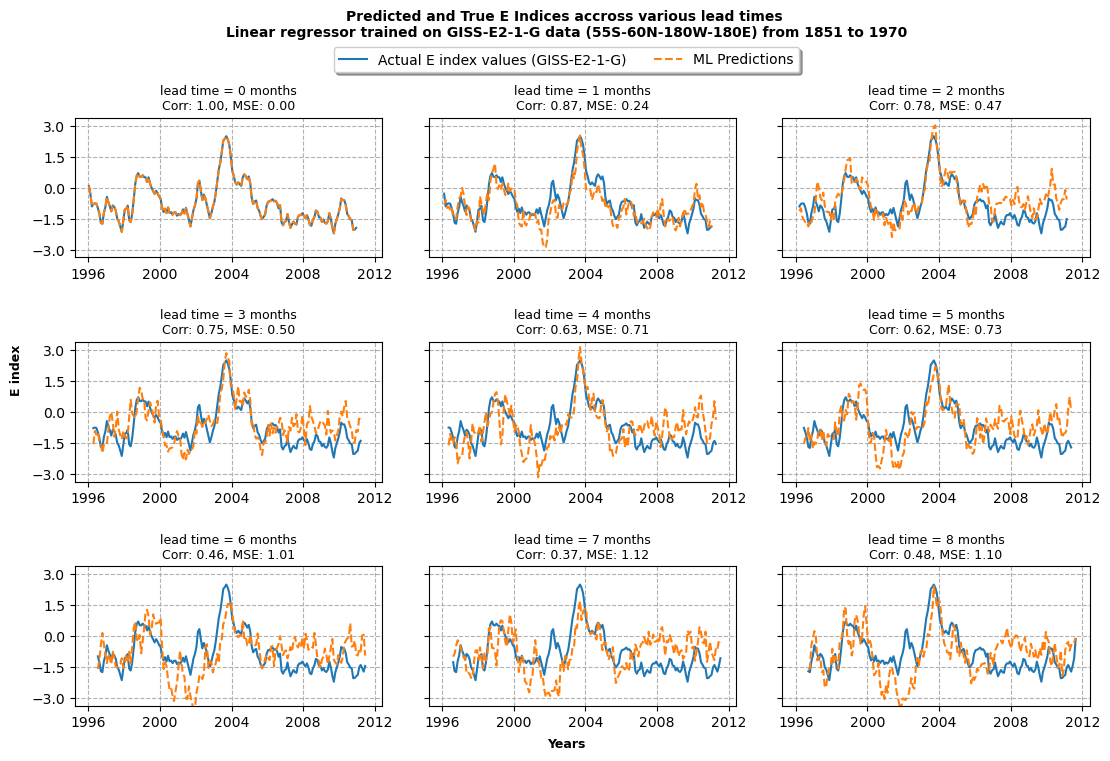

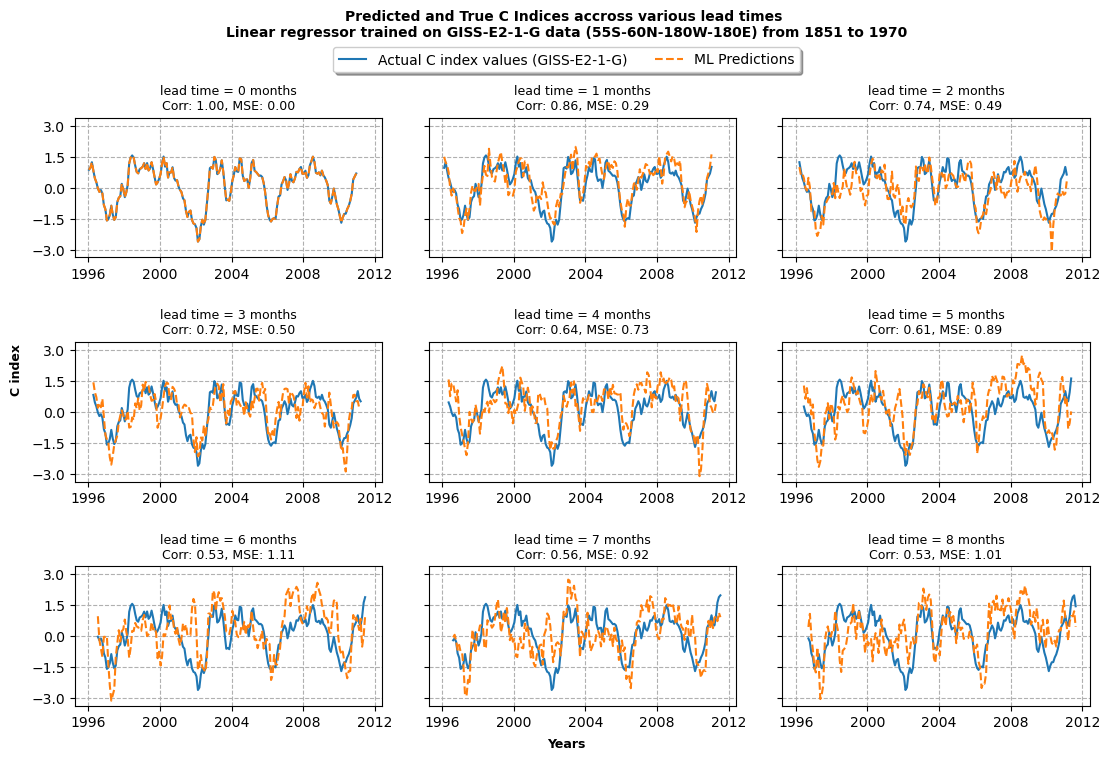

In [22]:
ROWS_TO_SHOW = 3

for target in ['E', 'C']:

    fig, axs = plt.subplots(nrows=ROWS_TO_SHOW, ncols=3, figsize=(11, ROWS_TO_SHOW*2.5), sharex=True, sharey=True)
    
    # Iterate over the linear regression models' results and their respective axes
    for lr_dict, ax in zip(lin_reg_results[target], axs.flat):
    
        # Align timestamps of predictions and actual values
        predictions = pd.Series(lr_dict['predictions'], index=lr_dict['y_test'].index)
        predictions = predictions.sort_index()
        y_test = lr_dict['y_test'].sort_index()


        # Plot machine learning predictions and actual values on the same plot
        ax.plot(y_test, label=f'Actual {target.capitalize()} index values ({source_id})')        
        ax.plot(predictions, '--', label='ML Predictions')
        ax.set_title(f"lead time = {lr_dict['lead_time']} months\nCorr: {lr_dict['corr']:.2f}, MSE: {lr_dict['mse']:.2f}", fontsize=9)
        ax.set_ylim(-abs_v_max, abs_v_max)
        ax.yaxis.set_major_locator(MultipleLocator(1.5))  # Set y-ticks at every 1.5 increment        
        ax.xaxis.set_major_locator(mdates.YearLocator(base=4))  # base=4 for every four year    
        ax.tick_params(axis='x', which='both', labelbottom=True) # ensure the x-axis labels are visible for each subplot
        ax.grid(linestyle='dashed')
        handles, labels = ax.get_legend_handles_labels()
        
    fig.legend(handles, [labels[0], labels[1]], loc='upper center', bbox_to_anchor=(0.5, 0.939), ncol=2, shadow=True)
    fig.suptitle(f'Predicted and True {target.capitalize()} Indices accross various lead times \n'
                 f'Linear regressor trained on {source_id} data ({utils.add_cardinals_fname(MIN_LAT, MAX_LAT, MIN_LON, MAX_LON)}) from {train_start_year} to {train_end_year}',
                 fontsize=10, fontweight="bold")
    fig.text(0.5, 0.0, 'Years', ha='center', va='center', fontsize=9, fontweight="bold")
    fig.text(0.00, 0.5,  f'{target} index', ha='center', va='center', rotation='vertical', fontsize=9, fontweight="bold")
    fig.tight_layout(h_pad=2, w_pad=2, rect=[0, 0, 1, 0.96]) # (left, bottom, right, top), default: (0, 0, 1, 1)

    if SAVE_PLOTS_TO_DISK == True:
        filename = f"plot_pred_true_timeseries_lin_reg_{source_id}_{target}Idx_Train{train_start_year}-{train_end_year}.jpg"
        fig.savefig(IMG_FOLDER+filename, dpi=300, bbox_inches='tight')
        print(f"Saved {filename} to disk")

    plt.show()
    print("\n\n\n\n")

#### Plot LR learned coefficients

##### Plot LR learned coefficients for lead time = 1

In [23]:
MIN_LAT

-55

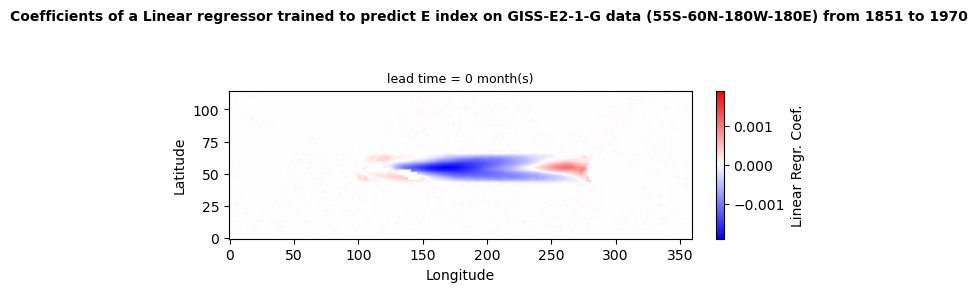

min and max coefficients: -0.0019, 0.0011




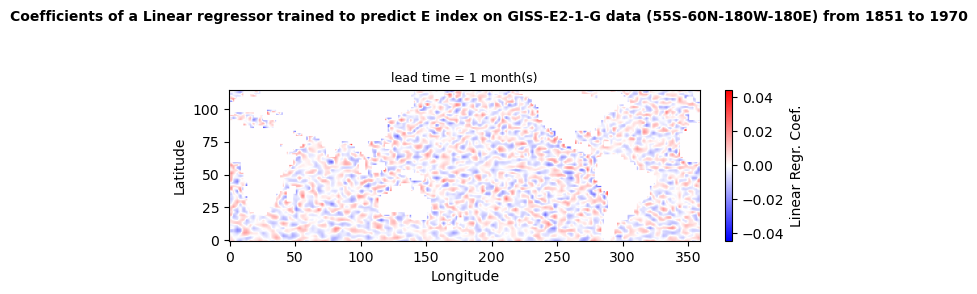

min and max coefficients: -0.0323, 0.0443




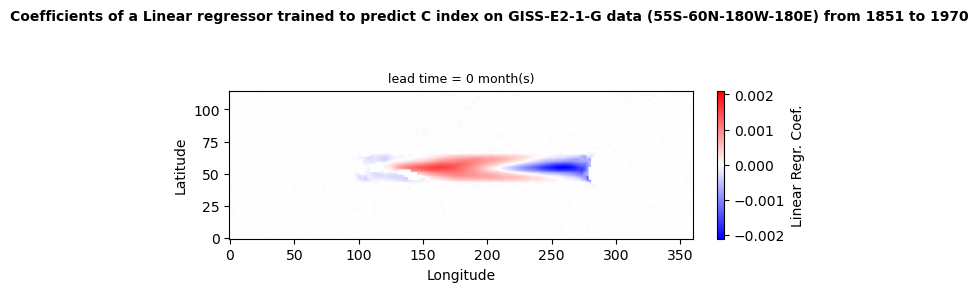

min and max coefficients: -0.0021, 0.0016




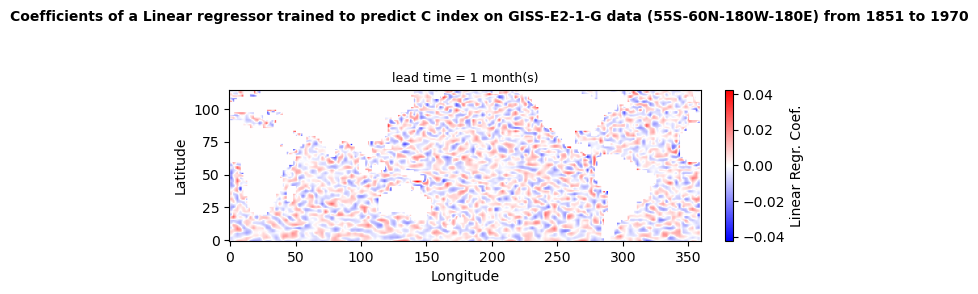

min and max coefficients: -0.0423, 0.0423




In [24]:
for target in ['E', 'C']:

    for lead_time in [0,1]: 

        fig, ax = plt.subplots(layout='compressed')
        
        # Get the first set of results, corresponding to 1 month lead time
        lr_dict = lin_reg_results[target][lead_time]
        weights = lr_dict['weights']
        
        
        # Since we want the colorbar to be symetrical around zero, we need to take the weights' maximum abs value and use it for vmin and vmax
        w_min, w_max = np.inf, -np.inf
        w_min = min(w_min, weights.min())
        w_max = max(w_max, weights.max())
        abs_w_max = max(abs(w_min), abs(w_max))
        
        # Reshape weights into a 2D grid corresponding to latitude and longitude dimensions
        # weights_2d = lr_dict['weights'].reshape((180,360))
        weights_2d = lr_dict['weights'].reshape((MAX_LAT-MIN_LAT,MAX_LON-MIN_LON))
        # print(weights_2d.shape)
        
        
        # Display the weights as a 2D image
        cax = ax.imshow(weights_2d, cmap='bwr', vmin=-abs_w_max, vmax=abs_w_max, origin='lower')
        ax.set_title(f"lead time = {lr_dict['lead_time']} month(s)", fontsize=9)
        ax.set_xlabel(f"Longitude")
        ax.set_ylabel(f"Latitude")
        
        # # Offset to start y-axis labels
        # offset = 20
        
        # # # Get default ticks and apply offset
        # yticks = ax.get_yticks().astype(int)
        # print(yticks)
        
        # # ticks = ticks[(ticks >= 0) & (ticks < weights_2d.shape[0])]  # Filter out tick positions outside data range
        # new_labels = [str(MIN_LAT + tick) for tick in ticks]
        # print(new_labels)
    
        # # # Set the new y-axis labels
        # ax.set_yticklabels(new_labels)
        
        # Create colorbar
        cb = plt.colorbar(cax, ax=ax, orientation='vertical')
        cb.set_label('Linear Regr. Coef.')
        
        suptitle = f'Coefficients of a Linear regressor trained to predict {target} index on {source_id} data ({utils.add_cardinals_fname(MIN_LAT, MAX_LAT, MIN_LON, MAX_LON)}) from {train_start_year} to {train_end_year}'
        
        fig.suptitle(suptitle, fontsize=10, fontweight="bold", y=0.85)
        plt.show()
        
        print(f"min and max coefficients: {w_min:.4f}, {w_max:.4f}\n\n")

In [25]:
(MAX_LAT-MIN_LAT)

115

##### Plot LR learned coefficients for all lead times

In [26]:
# # for different lead times
# # get min and max weight values across all datasets for shared color bar
# w_min, w_max = np.inf, -np.inf
# for lr_dict, ax in zip(lin_reg_results['E'], axs.flat):
#     weights = lr_dict['weights']
#     w_min = min(w_min, weights.min())
#     w_max = max(w_max, weights.max())

# # since we want the colorbar to be symetrical around zero, we need to take the maximum abs value and use it for min and max
# abs_w_max = max(abs(w_min), abs(w_max))
# abs_w_max


# fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 6), sharex=True, sharey=True)

# # Iterate over datasets and their respective axes
# for lr_dict, ax in zip(lin_reg_results['E'], axs.flat):
#     # weights = lr_dict['weights'].reshape((180,360))
#     weights = lr_dict['weights'].reshape((MAX_LAT-MIN_LAT,MAX_LON-MIN_LON))

#     im = ax.imshow(weights, cmap='bwr', vmin=-abs_w_max, vmax=abs_w_max, origin='lower')
#     ax.set_title(f"lead time = {lr_dict['lead_time']} months\nCorr: {lr_dict['corr']:.2f}, MSE: {lr_dict['mse']:.2f}", fontsize=9)
    
# # Tight layout
# fig.tight_layout()

# # Create a shared colorbar for the entire figure
# fig.subplots_adjust(right=0.9, hspace=0)  # Adjust the right margin to leave space for colorbar
# cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # axis for the color bar: [left, bottom, width, height] in figure coordinate
# cbar = fig.colorbar(im, cax=cbar_ax) # Create color bar
# cbar.set_label('Learned Linear Regression Weights') 

# suptitle = f'Coefficients from Linear Regression CoefficientsLinear regressor trained on {source_id} data ({utils.add_cardinals_fname(MIN_LAT, MAX_LAT, MIN_LON, MAX_LON)})from {test_start_year} to {test_end_year}'
# fig.suptitle(suptitle, fontsize=10, fontweight="bold")

# fig.text(0.5, 0.0, 'Longitue', ha='center', va='center', fontsize=9, fontweight="bold")
# fig.text(0.00, 0.5,  'Latitude', ha='center', va='center', rotation='vertical', fontsize=9, fontweight="bold")
# plt.show()

### Ridge Regression

#### Select best alpha using cross-validation
Select best regularization coefficient alpha using cross-validation

In [27]:
ridge_cv_results = {}
for target in ['E', 'C']:
    
    # perform cross-validation to select best regularization coefficient alpha
    lead_time = 1
    ridge_cv_results[target] = []
    
    # Assemble training and validation datasets for the specified lead time
    X_train, y_train = assemble_basic_predictors_predictands(source_id, target, train_start_date, train_end_date, lead_time=lead_time, lat_slice=LAT_SLICE, lon_slice=LON_SLICE, verbose=verbose)
    X_val, y_val = assemble_basic_predictors_predictands(source_id, target, val_start_date, val_end_date, lead_time=lead_time, lat_slice=LAT_SLICE, lon_slice=LON_SLICE, verbose=verbose)
    
    # Iterate over a list of different regularization strengths (alpha values)
    for alpha in [1, 10, 100, 1000, 5000, 8000, 10000, 80_000]:
        # Train the model on the training dataset using the specified regularization strength
        ridge_regr = sklearn.linear_model.Ridge(alpha=alpha)
        ridge_regr.fit(X_train,y_train)
    
        # Evaluate the model on the validation data
        predictions = ridge_regr.predict(X_val)
        corr, _ = scipy.stats.pearsonr(predictions, y_val)
        mse = mean_squared_error(y_val, predictions)
    
        # Store model performance metrics and coefficients in a dictionary for the current regularization strength
        cv_result = { 
        	'source_id': source_id, 
        	'lead_time': lead_time,
            'train_start_date': train_start_date,
            'train_end_date': train_end_date,
            
        	'alpha': alpha,
        	'corr': corr,
        	'mse': mse,
        }
        ridge_cv_results[target].append(cv_result)
        print(f'alpha = {alpha:>10}: Predicted and True {target} Indices at {lead_time} Months Lead Time: Corr: {corr:.5f}, MSE: {mse:.6f}')
    print()

alpha =          1: Predicted and True E Indices at 1 Months Lead Time: Corr: 0.84583, MSE: 0.161917
alpha =         10: Predicted and True E Indices at 1 Months Lead Time: Corr: 0.88119, MSE: 0.121429
alpha =        100: Predicted and True E Indices at 1 Months Lead Time: Corr: 0.92509, MSE: 0.077704
alpha =       1000: Predicted and True E Indices at 1 Months Lead Time: Corr: 0.93737, MSE: 0.065103
alpha =       5000: Predicted and True E Indices at 1 Months Lead Time: Corr: 0.93798, MSE: 0.064411
alpha =       8000: Predicted and True E Indices at 1 Months Lead Time: Corr: 0.93702, MSE: 0.065421
alpha =      10000: Predicted and True E Indices at 1 Months Lead Time: Corr: 0.93634, MSE: 0.066142
alpha =      80000: Predicted and True E Indices at 1 Months Lead Time: Corr: 0.91641, MSE: 0.087283

alpha =          1: Predicted and True C Indices at 1 Months Lead Time: Corr: 0.87320, MSE: 0.284176
alpha =         10: Predicted and True C Indices at 1 Months Lead Time: Corr: 0.90109, MSE

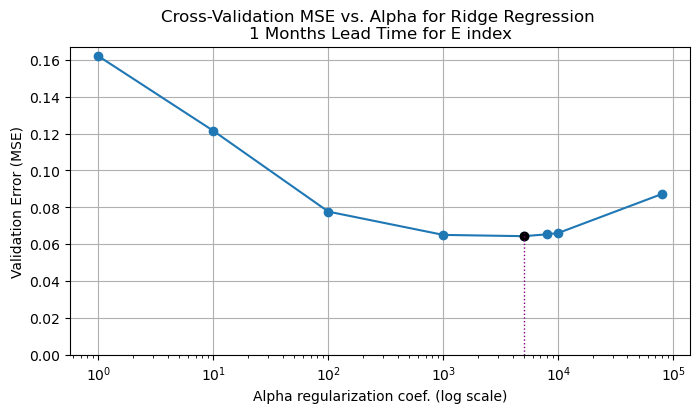

The regularization coefficient with the minimum MSE is alpha=5000 with an MSE of 0.0644


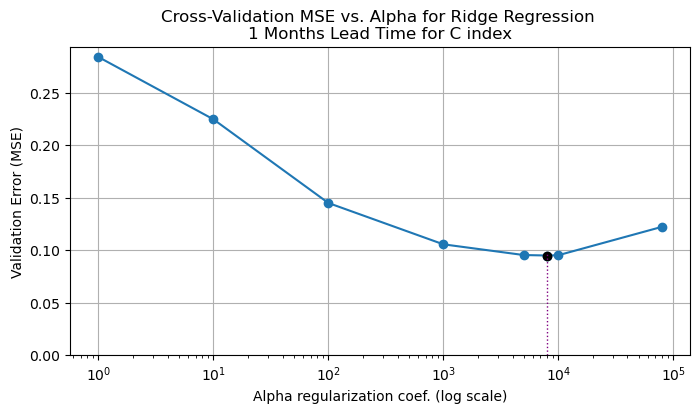

The regularization coefficient with the minimum MSE is alpha=8000 with an MSE of 0.0950


In [28]:
min_rmse_alpha = {}
for target in ['E', 'C']:
        
    # Extract alpha and mse values
    alphas = [entry['alpha'] for entry in ridge_cv_results[target]]
    rmses = [entry['mse'] for entry in ridge_cv_results[target]]
    
    # Find alpha value corresponding to the minimum MSE
    min_rmse_index = rmses.index(min(rmses))
    min_rmse_alpha[target] = alphas[min_rmse_index]
    
    # Plot MSE vs alpha values
    plt.figure(figsize=(8, 4))
    plt.plot(alphas, rmses, marker='o')  # Line plot with circle markers
    plt.plot(min_rmse_alpha[target], min(rmses), marker='o', c='black')  # Line plot with circle markers
    
    # Customize the plot
    plt.title(f'Cross-Validation MSE vs. Alpha for Ridge Regression \n{lead_time} Months Lead Time for {target} index')
    plt.xlabel('Alpha regularization coef. (log scale)')
    plt.ylabel('Validation Error (MSE)')
    plt.ylim([0, None])
    plt.xscale('log')
    plt.grid(True)
    plt.axvline(x=min_rmse_alpha[target], ymin=0,  ymax=min(rmses)/max(rmses), color='purple', linestyle='dotted', linewidth=1)
    plt.show()    
    
    print(f"The regularization coefficient with the minimum MSE is alpha={min_rmse_alpha[target]} with an MSE of {min(rmses):.4f}")
    

#### Train Ridge regression models across different lead times

Train Ridge regression models across different lead times and evaluate their performance in predicting ONI indices 

In [29]:
verbose = False
ridge_reg_results = {}
for target in ['E', 'C']:
    
    alpha = min_rmse_alpha[target]
    
    print(f"Ridge regressor trained to predict {target} index on {source_id} data ({utils.add_cardinals_fname(MIN_LAT, MAX_LAT, MIN_LON, MAX_LON)}) from {train_start_date} to {train_end_date}")
    ridge_reg_results[target] = []
    
    for lead_time in range(0, MAX_LEAD_TIME, 1):
    
        # Assemble training and validation datasets for the specified lead time
        X_train, y_train = assemble_basic_predictors_predictands(source_id, target, train_start_date, train_end_date, lead_time=lead_time, lat_slice=LAT_SLICE, lon_slice=LON_SLICE, verbose=verbose)
        X_test, y_test = assemble_basic_predictors_predictands(source_id, target, test_start_date, test_end_date, lead_time=lead_time, lat_slice=LAT_SLICE, lon_slice=LON_SLICE, verbose=verbose)
        
        # Train a Ridge regression model using the training data
        ridge_regr = sklearn.linear_model.Ridge(alpha=alpha)
        ridge_regr.fit(X_train,y_train)
    
        # Evaluate the model on the validation data
        predictions = ridge_regr.predict(X_test)
        corr, _ = scipy.stats.pearsonr(predictions, y_test)
        mse = mean_squared_error(y_test, predictions)
    
        # Store model performance metrics and coefficients in a dictionary for the current lead time
        result_dict = { 
        	'lead_time': lead_time,
        	'y_test': y_test,
        	'predictions': predictions,
        	'corr': corr, 
        	'mse': mse,
            'weights': regr.coef_,
            'alpha': alpha,
        }
        ridge_reg_results[target].append(result_dict)
        
        print(f'Predicted and True {target} Indices at {lead_time} Months Lead Time: Corr: {corr:.2f}, MSE: {mse:.2f}')
        # plot_nino_time_series(y_test, predictions, source_id,
        #     f'Predicted and True {target} indices at {lead_time} Month Lead Time\nCorr: {corr:.2f}, MSE: {mse:.2f}')
    print()

Ridge regressor trained to predict E index on GISS-E2-1-G data (55S-60N-180W-180E) from 1851-01-01 to 1970-12-31
Predicted and True E Indices at 0 Months Lead Time: Corr: 1.00, MSE: 0.00
Predicted and True E Indices at 1 Months Lead Time: Corr: 0.97, MSE: 0.07
Predicted and True E Indices at 2 Months Lead Time: Corr: 0.93, MSE: 0.17
Predicted and True E Indices at 3 Months Lead Time: Corr: 0.87, MSE: 0.27
Predicted and True E Indices at 4 Months Lead Time: Corr: 0.81, MSE: 0.35
Predicted and True E Indices at 5 Months Lead Time: Corr: 0.75, MSE: 0.48
Predicted and True E Indices at 6 Months Lead Time: Corr: 0.69, MSE: 0.58
Predicted and True E Indices at 7 Months Lead Time: Corr: 0.64, MSE: 0.67
Predicted and True E Indices at 8 Months Lead Time: Corr: 0.60, MSE: 0.73
Predicted and True E Indices at 9 Months Lead Time: Corr: 0.54, MSE: 0.81
Predicted and True E Indices at 10 Months Lead Time: Corr: 0.48, MSE: 0.92
Predicted and True E Indices at 11 Months Lead Time: Corr: 0.44, MSE: 1.

#### Plot RR forecasts versus actual E and C time series

In [30]:
# y_test

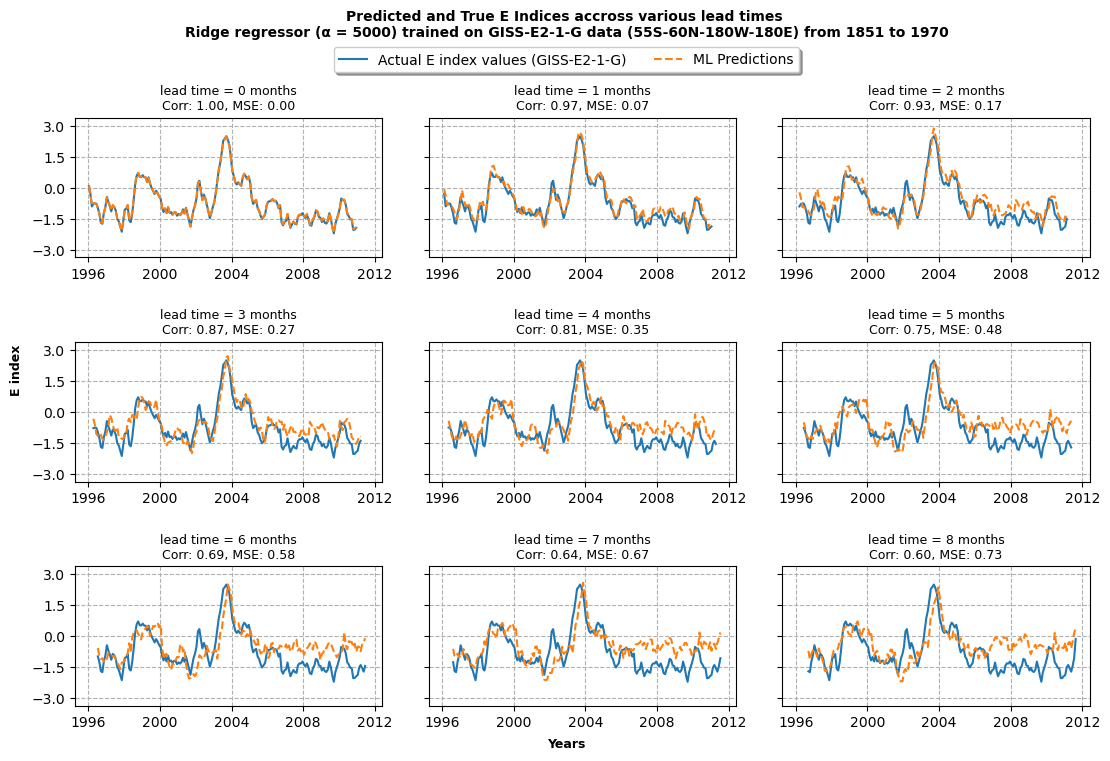

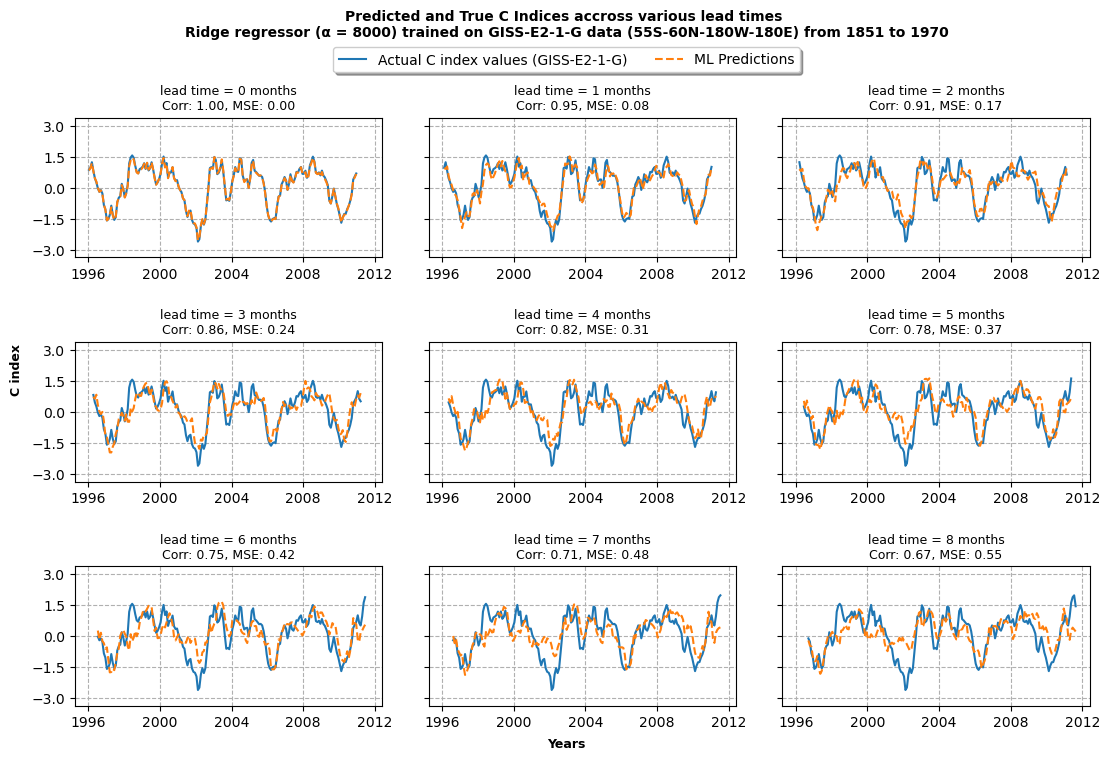

In [31]:
ROWS_TO_SHOW = 3

for target in ['E', 'C']:

    fig, axs = plt.subplots(nrows=ROWS_TO_SHOW, ncols=3, figsize=(11, ROWS_TO_SHOW*2.5), sharex=True, sharey=True)

    # Iterate over the ridge regression models' results and their respective axes
    for rr_dict, ax in zip(ridge_reg_results[target], axs.flat):
        alpha = rr_dict['alpha']
    
        y_test
        # Align timestamps of predictions and actual values
        predictions = pd.Series(rr_dict['predictions'], index=rr_dict['y_test'].index)
        predictions = predictions.sort_index()
        y_test = rr_dict['y_test'].sort_index()
    
        # Plot machine learning predictions and actual values on the same plot
        ax.plot(y_test, label=f'Actual {target.capitalize()} index values ({source_id})')
        ax.plot(predictions, '--', label='ML Predictions')
        
        ax.set_title(f"lead time = {rr_dict['lead_time']} months\nCorr: {rr_dict['corr']:.2f}, MSE: {rr_dict['mse']:.2f}", fontsize=9)
        ax.set_ylim(-abs_v_max, abs_v_max)
        ax.yaxis.set_major_locator(MultipleLocator(1.5))  # Set y-ticks at every 1.5 increment    
        ax.xaxis.set_major_locator(mdates.YearLocator(base=4))  # base=2 for every other year    
        ax.tick_params(axis='x', which='both', labelbottom=True) # Ensure the x-axis labels are visible for each subplot
        ax.grid(linestyle='dashed')
        handles, labels = ax.get_legend_handles_labels()
        
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.939), ncol=2, shadow=True)
    fig.suptitle(f'Predicted and True {target.capitalize()} Indices accross various lead times \n'
                 f'Ridge regressor (α = {alpha}) trained on {source_id} data ({utils.add_cardinals_fname(MIN_LAT, MAX_LAT, MIN_LON, MAX_LON)}) from {train_start_year} to {train_end_year}',
                 fontsize=10, fontweight="bold")

    fig.text(0.5, 0.0, 'Years', ha='center', va='center', fontsize=9, fontweight="bold")
    fig.text(0.00, 0.5,  f'{target} index', ha='center', va='center', rotation='vertical', fontsize=9, fontweight="bold")
    fig.tight_layout(h_pad=2, w_pad=2, rect=[0, 0, 1, 0.96]) # (left, bottom, right, top), default: (0, 0, 1, 1)

    if SAVE_PLOTS_TO_DISK == True:
        filename = f"plot_pred_true_timeseries_ridge_reg_{source_id}_{target}Idx_Train{train_start_year}-{train_end_year}.jpg"
        fig.savefig(IMG_FOLDER+filename, dpi=300, bbox_inches='tight')
        print(f"Saved {filename} to disk")
        
    plt.show()

#### Plot RR learned coefficients

##### Plot RR learned coefficients for lead time = 1

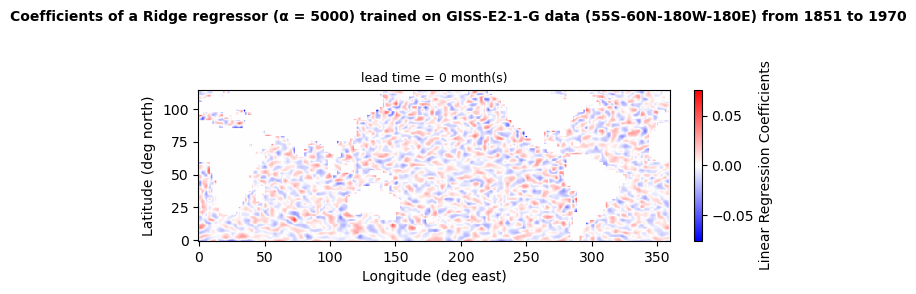

min and max coefficients: -0.0758, 0.0596


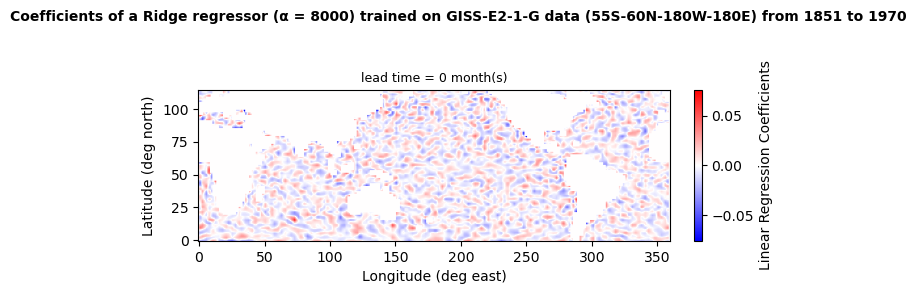

min and max coefficients: -0.0758, 0.0596


In [32]:
for target in ['E', 'C']:
    
    fig, ax = plt.subplots(layout='compressed')
    
    # Get the first set of results, corresponding to 1 month lead time
    rr_dict = ridge_reg_results[target][0]
    weights = rr_dict['weights']
    alpha = rr_dict['alpha']
    
    # Since we want the colorbar to be symetrical around zero, we need to take the weights' maximum abs value and use it for vmin and vmax
    w_min, w_max = np.inf, -np.inf
    w_min = min(w_min, weights.min())
    w_max = max(w_max, weights.max())
    abs_w_max = max(abs(w_min), abs(w_max))
    
    # Reshape weights into a 2D grid corresponding to latitude and longitude dimensions
    # weights_2d = rr_dict['weights'].reshape((180,360))
    weights_2d = rr_dict['weights'].reshape((MAX_LAT-MIN_LAT,MAX_LON-MIN_LON))
    
    
    # Display the weights as a 2D image
    cax = ax.imshow(weights_2d, cmap='bwr', vmin=-abs_w_max, vmax=abs_w_max, origin='lower')
    ax.set_title(f"lead time = {rr_dict['lead_time']} month(s)", fontsize=9)
    ax.set_xlabel(f"Longitude (deg east)")
    ax.set_ylabel(f"Latitude (deg north)")
    
    # Create colorbar
    cb = plt.colorbar(cax, ax=ax, orientation='vertical')
    cb.set_label('Linear Regression Coefficients')
    
    suptitle = f'Coefficients of a Ridge regressor (α = {alpha}) trained on {source_id} data ({utils.add_cardinals_fname(MIN_LAT, MAX_LAT, MIN_LON, MAX_LON)}) from {train_start_year} to {train_end_year}'
    fig.suptitle(suptitle, fontsize=10, fontweight="bold", y=0.85)
    plt.show()
    
    print(f"min and max coefficients: {w_min:.4f}, {w_max:.4f}")

### Persistence Forecast

#### Train Persistence Model

In [33]:
ts = {}
for target in ['E', 'C']:
    
    ts[target] = load_target_timeseries(source_id=source_id, target=target, start_date=test_start_date, end_date=test_end_date, verbose=True)
    ts[target]


• Search for `GISS-E2-1-G` target file in datasets/CMIP6/CMIP6_regridded/ec_indices
• Load CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn_cellarea.pca_ec_indices.txt (1850-01-16 to 2014-12-16)
• Extract E time series
• Slice the time period from 1996-01-01 to 2010-12-31
• The dimensions are: (180,): 180 months, 1 target value per month


• Search for `GISS-E2-1-G` target file in datasets/CMIP6/CMIP6_regridded/ec_indices
• Load CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn_cellarea.pca_ec_indices.txt (1850-01-16 to 2014-12-16)
• Extract C time series
• Slice the time period from 1996-01-01 to 2010-12-31
• The dimensions are: (180,): 180 months, 1 target value per month



In [34]:
# convert time series to dataframe
df_dict = {}
for target in ['E', 'C']:
        
    df_dict[target] = ts[target].to_frame()
    
    for lead_time in range(1, MAX_LEAD_TIME+1, 1): 
        col = "t"+str(lead_time)
        df_dict[target][col] = df_dict[target][target].shift(lead_time)
    display(df_dict[target].head())

,E,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13
1996-01-16 12:00:00,0.075370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-02-15 00:00:00,-0.288552,0.075370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-16 12:00:00,-0.902695,-0.288552,0.075370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-04-16 00:00:00,-0.783204,-0.902695,-0.288552,0.075370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-05-16 12:00:00,-0.755643,-0.783204,-0.902695,-0.288552,0.07537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,C,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13
1996-01-16 12:00:00,0.861820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-02-15 00:00:00,0.961889,0.861820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-16 12:00:00,1.232890,0.961889,0.861820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-04-16 00:00:00,0.820127,1.232890,0.961889,0.861820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-05-16 12:00:00,0.458568,0.820127,1.232890,0.961889,0.86182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
# drop rows containing missing values
for target in ['E', 'C']:
    df_dict[target] = df_dict[target].dropna(axis=0)
    # display(df_dict[target].head(3))

In [36]:
valid_start_year_dict = {}
valid_end_year_dict = {}
for target in ['E', 'C']:

    valid_start_year_dict[target] = df_dict[target].index[0].date().year
    valid_end_year_dict[target] = df_dict[target].index[-1].date().year
    
    print(f"{target} valid Test start and end years after dropping NaNs: {valid_start_year_dict[target]}-{valid_end_year_dict[target]}")

E valid Test start and end years after dropping NaNs: 1997-2010
C valid Test start and end years after dropping NaNs: 1997-2010


In [37]:
persist_model_results = {}
for target in ['E', 'C']:

    y_test = df_dict[target][target]
    correlations = []
    mses = []
    persist_model_results[target] = []
    
    
    # Iterate over the different timestep predictions and their respective axes
    for lead_time, col in enumerate(df_dict[target].columns):
        predictions = df_dict[target][col]
        
        # Evaluate the model on the validation data
        corr, _ = scipy.stats.pearsonr(predictions, y_test)
        mse = mean_squared_error(y_test, predictions)
    
        correlations.append(corr)
        mses.append(mse)
        
        # Store model performance metrics and coefficients in a dictionary for the current lead time
        result_dict = { 
        	'lead_time': lead_time,
        	'y_test': y_test,
        	'predictions': predictions,
        	'corr': corr, 
        	'mse': mse,
        }
        persist_model_results[target].append(result_dict)
    
        print(f'Predicted and True {target} Indices at {lead_time} Months Lead Time: Corr: {corr:.3f}, MSE: {mse:.3f}')
    print()


Predicted and True E Indices at 0 Months Lead Time: Corr: 1.000, MSE: 0.000
Predicted and True E Indices at 1 Months Lead Time: Corr: 0.955, MSE: 0.085
Predicted and True E Indices at 2 Months Lead Time: Corr: 0.873, MSE: 0.236
Predicted and True E Indices at 3 Months Lead Time: Corr: 0.778, MSE: 0.409
Predicted and True E Indices at 4 Months Lead Time: Corr: 0.683, MSE: 0.587
Predicted and True E Indices at 5 Months Lead Time: Corr: 0.591, MSE: 0.756
Predicted and True E Indices at 6 Months Lead Time: Corr: 0.507, MSE: 0.912
Predicted and True E Indices at 7 Months Lead Time: Corr: 0.435, MSE: 1.043
Predicted and True E Indices at 8 Months Lead Time: Corr: 0.376, MSE: 1.153
Predicted and True E Indices at 9 Months Lead Time: Corr: 0.327, MSE: 1.243
Predicted and True E Indices at 10 Months Lead Time: Corr: 0.295, MSE: 1.302
Predicted and True E Indices at 11 Months Lead Time: Corr: 0.282, MSE: 1.326
Predicted and True E Indices at 12 Months Lead Time: Corr: 0.286, MSE: 1.319
Predicted

#### Plot Persistence Forecasts accross different lead times

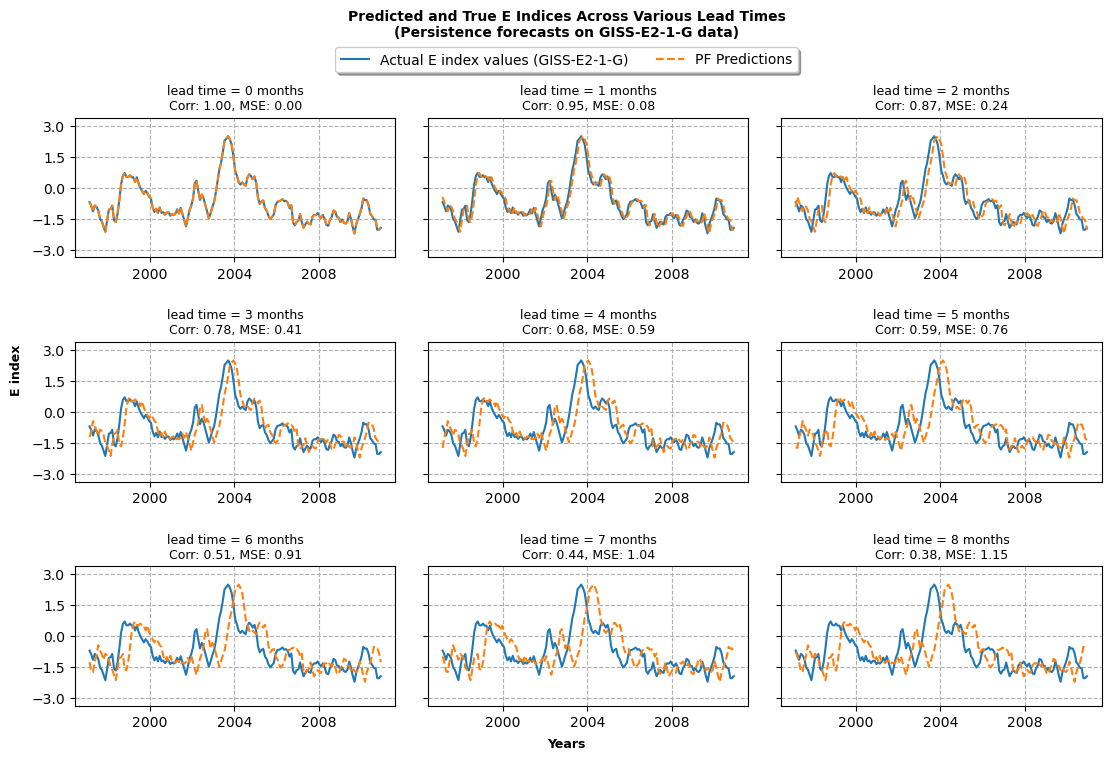

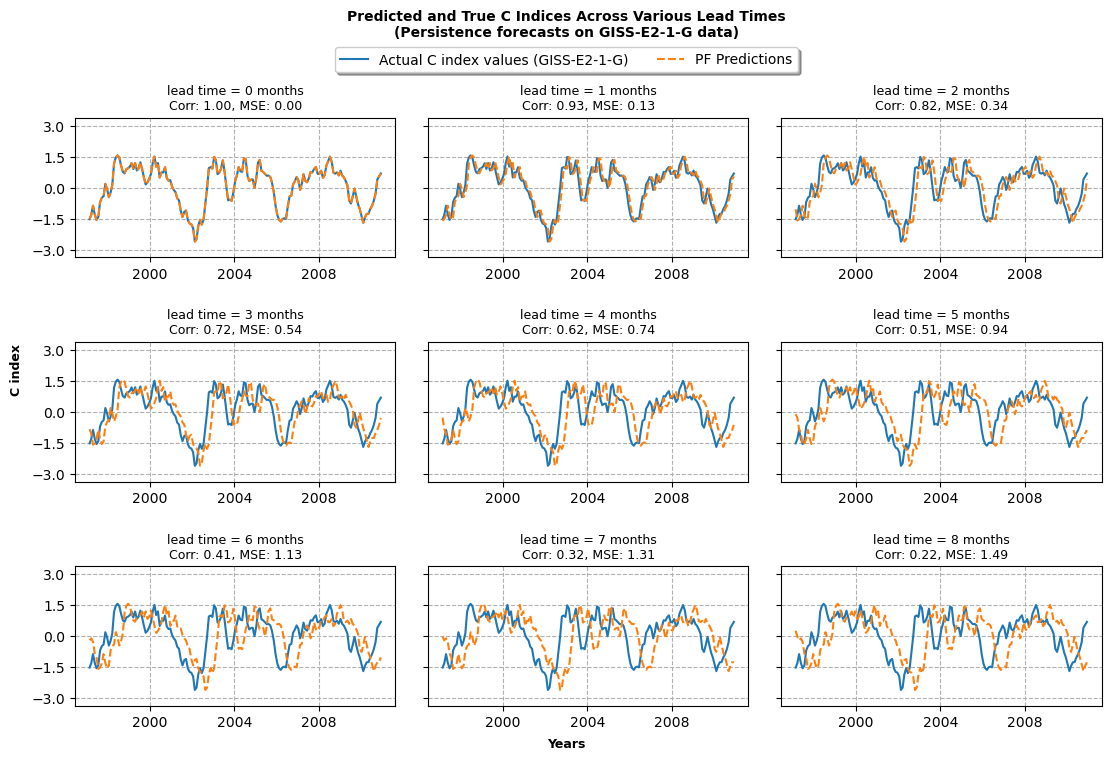

In [38]:
ROWS_TO_SHOW = 3

for target in ['E', 'C']:

    fig, axs = plt.subplots(nrows=ROWS_TO_SHOW, ncols=3, figsize=(11, ROWS_TO_SHOW*2.5), sharex=True, sharey=True)
    
    # Iterate over the ridge regression models' results and their respective axes
    for pf_dict, ax in zip(persist_model_results[target], axs.flat):
    
        # Align timestamps of predictions and actual values
        predictions = pd.Series(pf_dict['predictions'], index=pf_dict['y_test'].index)
        predictions = predictions.sort_index()
        y_test = pf_dict['y_test'].sort_index()
    
        # Plot machine learning predictions and actual values on the same plot
        ax.plot(y_test, label=f'Actual {target.capitalize()} index values ({source_id})')
        ax.plot(predictions, '--', label='PF Predictions')
        
        ax.set_title(f"lead time = {pf_dict['lead_time']} months\nCorr: {pf_dict['corr']:.2f}, MSE: {pf_dict['mse']:.2f}", fontsize=9)
        ax.set_ylim(-abs_v_max, abs_v_max)
        ax.yaxis.set_major_locator(MultipleLocator(1.5))  # Set y-ticks at every 1.5 increment    
        ax.xaxis.set_major_locator(mdates.YearLocator(base=4))  # base=2 for every other year    
        ax.tick_params(axis='x', which='both', labelbottom=True) # Ensure the x-axis labels are visible for each subplot
        ax.grid(linestyle='dashed')
        handles, labels = ax.get_legend_handles_labels()
        
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.939), ncol=2, shadow=True)
    # fig.suptitle(f'Predicted and True {target} Indices accross various lead times\nRidge regressor (α = {alpha}) trained on {source_id} data ({utils.add_cardinals_fname(MIN_LAT, MAX_LAT, MIN_LON, MAX_LON)})from {test_start_year} to {test_end_year}', fontweight="bold")
    fig.suptitle(f'Predicted and True {target} Indices Across Various Lead Times\n(Persistence forecasts on {source_id} data)', fontweight="bold", fontsize=10)
    
    fig.text(0.5, 0.0, 'Years', ha='center', va='center', fontsize=9, fontweight="bold")
    fig.text(0.00, 0.5,  f'{target} index', ha='center', va='center', rotation='vertical', fontsize=9, fontweight="bold")
    fig.tight_layout(h_pad=2, w_pad=2, rect=[0, 0, 1, 0.96]) # (left, bottom, right, top), default: (0, 0, 1, 1)

    
    if SAVE_PLOTS_TO_DISK == True:
        filename = f"plot_pred_true_timeseries_pers_for_{source_id}_{target}Idx_Train{train_start_year}-{train_end_year}.jpg"
        fig.savefig(IMG_FOLDER+filename, dpi=300, bbox_inches='tight')
        print(f"Saved {filename} to disk")
        
    plt.show()

In [39]:
# fig, axs = plt.subplots(nrows=int(max_time_steps/3), ncols=3, figsize=(12, 8), sharex=True, sharey=True)

# y_test = df[target]
# correlations = []
# mses = []

# # Iterate over the different timestep predictions and their respective axes
# for i, (col, ax) in enumerate(zip(df.columns, axs.flat)):

#     predictions = df[col]
    
#     # Evaluate the model on the validation data
#     corr, _ = scipy.stats.pearsonr(predictions, y_test)
#     mse = mean_squared_error(y_test, predictions)

#     correlations.append(corr)
#     mses.append(mse)
    
#     # Store model performance metrics and coefficients in a dictionary for the current lead time
#     result_dict = { 
#     	'lead_time': i,
#     	'y_test': y_test,
#     	'predictions': predictions,
#     	'corr': corr, 
#     	'mse': mse,
#     }
#     persist_model_results.append(result_dict)

#     print(f'Predicted and True {target} Indices at {lead_time} Months Lead Time: Corr: {corr:.3f}, MSE: {mse:.3f}')

    
#     # Plot Naive predictions and actual values on the same plot
#     ax.plot(y_test, label=f'Actual Data')
#     ax.plot(predictions, label="Persistence Forecast", linestyle='--')

#     ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
#     ax.xaxis.set_major_locator(mdates.YearLocator(base=2))  # base=2 for every other year    
#     ax.xaxis.set_minor_locator(mdates.YearLocator(1))

#     ax.set_title(f"lead time = {i} month(s)\nCorr: {corr:.2f}, mse: {mse:.2f}", fontsize=9)
#     ax.tick_params(axis='x', which='both', labelbottom=True) # ensure the x-axis labels are visible for each subplot

#     # ax.grid(linestyle='dashed')
#     ax.grid(True, which='both', linestyle='--', linewidth=0.5)

#     # Set the y-label for the leftmost subplot in each row
#     if i % 3 == 0:
#         ax.set_ylabel('Niño 3.4 index [°C]', fontsize=9)
        
#     handles, labels = ax.get_legend_handles_labels()
    
# fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.968), ncol=2, shadow=True)

# fig.suptitle(f'Persistence Forecasts vs. Niño 3.4 Indices Across Various Lead Times\n({source_id} data between {val_start_year} and {val_end_year})', fontweight="bold", fontsize=10)
# fig.text(0.5, 0.0, 'Date', ha='center', va='center', fontsize=9, fontweight="bold")
# # fig.text(0.00, 0.5,  'Niño 3.4 index (°C)', ha='center', va='center', rotation='vertical', fontsize=9, fontweight="bold")
# fig.tight_layout(h_pad=2, w_pad=None, rect=[0, 0, 1, 0.97]) # (left, bottom, right, top), default: (0, 0, 1, 1)


# # if SAVE_PLOTS_TO_DISK == True:
# #     filename = "plot_nino34_persistence_timeseries_"+source_id+"_"+val_start_year+"-"+val_end_year+".jpg"
# #     fig.savefig(IMG_FOLDER+filename, dpi=300, bbox_inches='tight')
# #     print(f"Saved {filename} to disk")
    
# plt.show()

## Compare ML predictions with baseline Persistence forecast

In [49]:

# for target in ['E', 'C']:

#     fig, axs = plt.subplots(nrows=ROWS_TO_SHOW, ncols=3, figsize=(11, ROWS_TO_SHOW*2.5), sharex=True, sharey=True)

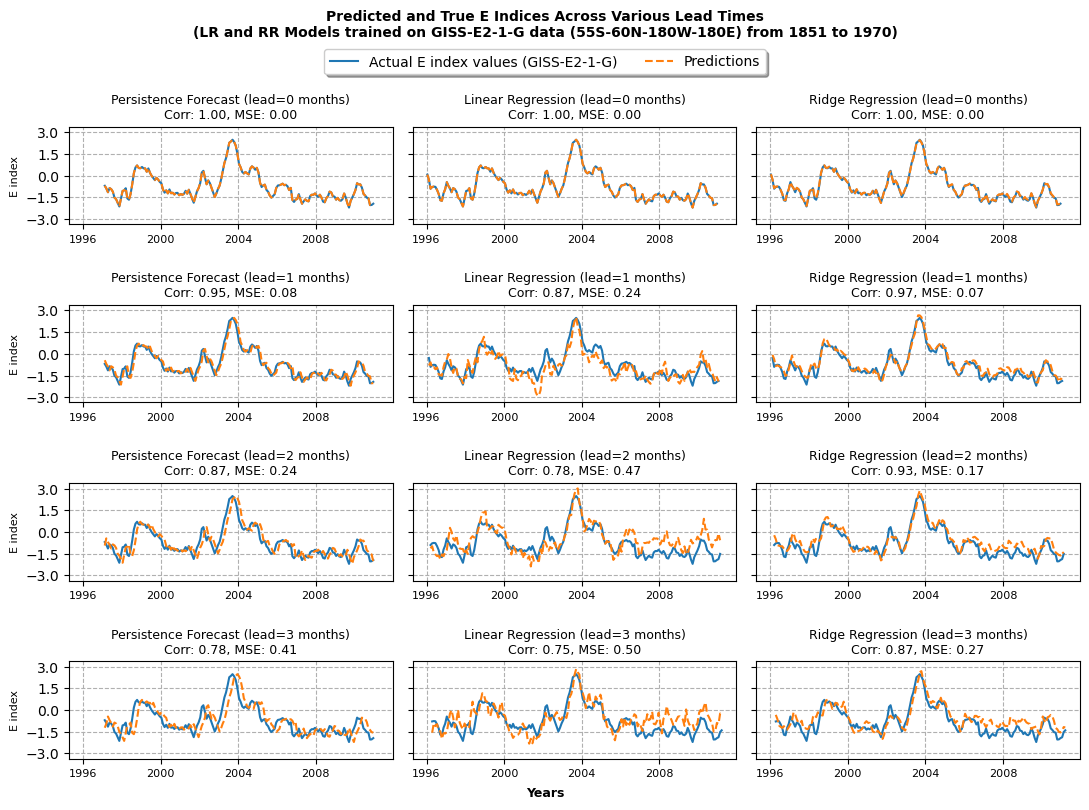

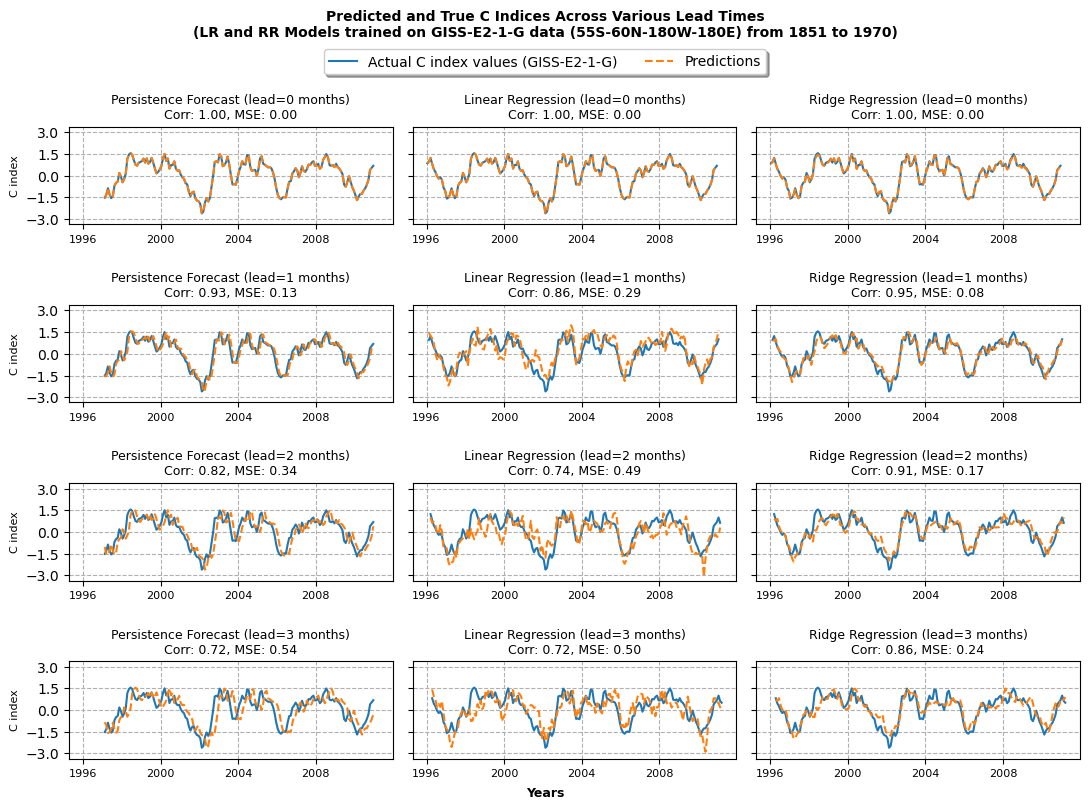

In [41]:
ROWS_TO_SHOW = 4

for target in ['E', 'C']:

    # fig, axs = plt.subplots(nrows=min(len(lin_reg_results[target]), 9), ncols=3, figsize=(10, 18), sharex=True, sharey=True)
    fig, axs = plt.subplots(nrows=ROWS_TO_SHOW, ncols=3, figsize=(11, ROWS_TO_SHOW*2), sharex=True, sharey=True)
    
    for (pf_dict, lr_dict, rr_dict), (ax1, ax2, ax3) in zip(zip(persist_model_results[target], lin_reg_results[target], ridge_reg_results[target]), axs):
    
        
        ######## PERSISTENCE FORECASTS ########
        
        # Align timestamps of predictions and actual values
        pf_predictions = pd.Series(pf_dict['predictions'], index=pf_dict['y_test'].index)
        pf_predictions = pf_predictions.sort_index()
        y_test = pf_dict['y_test'].sort_index()
    
        # Plot machine learning predictions and actual values on the same plot
        ax1.plot(y_test, label=f'Actual {target.capitalize()} index values ({source_id})')
        ax1.plot(pf_predictions, '--', label='PF Predictions')
        
        ax1.set_title(f"Persistence Forecast (lead={pf_dict['lead_time']} months)\nCorr: {pf_dict['corr']:.2f}, MSE: {pf_dict['mse']:.2f}", fontsize=9)
        ax1.set_ylim(-abs_v_max, abs_v_max)
        ax1.yaxis.set_major_locator(MultipleLocator(1.5))  # Set y-ticks at every 1.5 increment    
        ax1.xaxis.set_major_locator(mdates.YearLocator(base=4))  # base=4 for every four year    
        ax1.tick_params(axis='x', which='both', labelbottom=True, labelsize=8) # ensure the x-axis labels are visible for each subplot
        ax1.grid(linestyle='dashed')
        ax1.set_ylabel(f'{target} index', fontsize=8) # Set the y-label for the leftmost subplot in each row
        handles, labels = ax1.get_legend_handles_labels()
    
        
        ######## LINEAR REGRESSION ########
        
        # Align timestamps of predictions and actual values
        lr_predictions = pd.Series(lr_dict['predictions'], index=lr_dict['y_test'].index)
        lr_predictions = lr_predictions.sort_index()
        y_test = lr_dict['y_test'].sort_index()
    
        # Plot machine learning predictions and actual values on the same plot
        ax2.plot(y_test, label=f'Actual {target.capitalize()} index values ({source_id})')
        ax2.plot(lr_predictions, '--', label='LR Predictions')
        
        ax2.set_title(f"Linear Regression (lead={lr_dict['lead_time']} months)\nCorr: {lr_dict['corr']:.2f}, MSE: {lr_dict['mse']:.2f}", fontsize=9)
        ax2.xaxis.set_major_locator(mdates.YearLocator(base=4))  # base=4 for every four year    
        ax2.tick_params(axis='x', which='both', labelbottom=True, labelsize=8) # ensure the x-axis labels are visible for each subplot
        ax2.grid(linestyle='dashed')
        handles, labels = ax2.get_legend_handles_labels()
    
        
        ######## RIDGE REGRESSION ########
        
        # Align timestamps of predictions and actual values
        rr_predictions = pd.Series(rr_dict['predictions'], index=rr_dict['y_test'].index)
        rr_predictions = rr_predictions.sort_index()
        y_test = rr_dict['y_test'].sort_index()
    
        # Plot machine learning predictions and actual values on the same plot
        ax3.plot(y_test, label=f'Actual {target.capitalize()} index values ({source_id})')
        ax3.plot(rr_predictions, '--', label='RR Predictions')
        
        ax3.set_title(f"Ridge Regression (lead={rr_dict['lead_time']} months)\nCorr: {rr_dict['corr']:.2f}, MSE: {rr_dict['mse']:.2f}", fontsize=9)
        ax3.xaxis.set_major_locator(mdates.YearLocator(base=4))  # base=4 for every four year    
        ax3.tick_params(axis='x', which='both', labelbottom=True, labelsize=8) # ensure the x-axis labels are visible for each subplot
        ax3.grid(linestyle='dashed')
        handles, labels = ax3.get_legend_handles_labels()
    
    fig.legend(handles, [labels[0], "Predictions"], loc='upper center', bbox_to_anchor=(0.5, 0.939), ncol=2, shadow=True)
    fig.suptitle(f'Predicted and True {target} Indices Across Various Lead Times\n(LR and RR Models trained on {source_id} data ({utils.add_cardinals_fname(MIN_LAT, MAX_LAT, MIN_LON, MAX_LON)}) from {train_start_year} to {train_end_year})', fontsize=10, fontweight="bold")
    fig.text(0.5, 0.0, 'Years', ha='center', va='center', fontsize=9, fontweight="bold")
    fig.tight_layout(h_pad=2, w_pad=None, rect=[0, 0, 1, 0.95]) # (left, bottom, right, top), default: (0, 0, 1, 1)

    
    
    if SAVE_PLOTS_TO_DISK == True:
        filename = f"plot_pred_true_timeseries_reg_model_comparison_{source_id}_{target}Idx_Train{train_start_year}-{train_end_year}.jpg"
        fig.savefig(IMG_FOLDER+filename, dpi=300, bbox_inches='tight')
        print(f"Saved {filename} to disk")
    
    plt.show()

In [42]:
pf_correlations, lr_correlations, rr_correlations = {}, {}, {}
pf_mses, lr_mses, rr_mses = {}, {}, {}

for target in ['E', 'C']:

    pf_correlations[target] = [pf_dict['corr'] for pf_dict in persist_model_results[target]]
    lr_correlations[target] = [lr_dict['corr'] for lr_dict in lin_reg_results[target]]
    rr_correlations[target] = [rr_dict['corr'] for rr_dict in ridge_reg_results[target]]
    
    pf_mses[target] = [pf_dict['mse'] for pf_dict in persist_model_results[target]]
    lr_mses[target] = [lr_dict['mse'] for lr_dict in lin_reg_results[target]]
    rr_mses[target] = [rr_dict['mse'] for rr_dict in ridge_reg_results[target]]

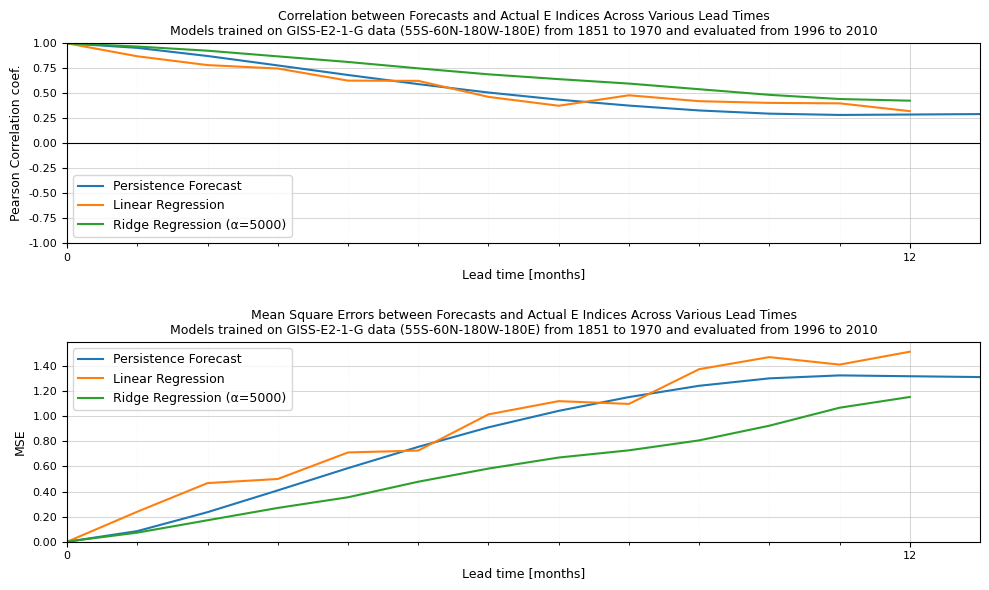

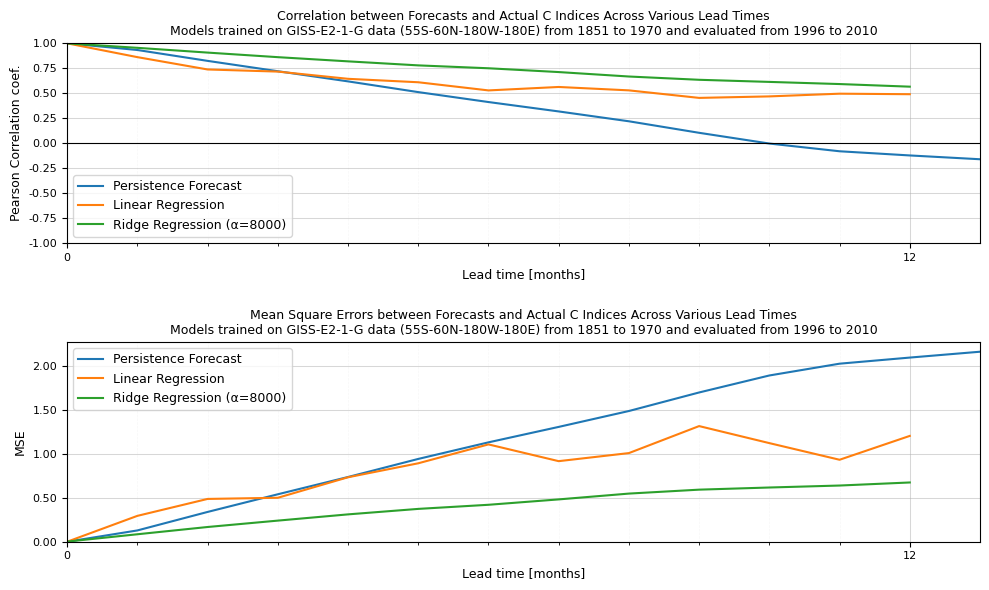

In [43]:
for target in ['E', 'C']:

    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
    
    for i, ax in enumerate(axs.flat):
        if i == 0:
            ax.plot(range(0, len(pf_correlations[target])), pf_correlations[target], label="Persistence Forecast")        
            ax.plot(range(0, len(lr_correlations[target])), lr_correlations[target], label="Linear Regression")        
            ax.plot(range(0, len(rr_correlations[target])), rr_correlations[target], label=f"Ridge Regression (α={min_rmse_alpha[target]})")        
            ax.set_ylabel('Pearson Correlation coef.', fontsize=9)
            ax.set_ylim(-1,1)
            ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
            ax.set_title(f'Correlation between Forecasts and Actual {target} Indices Across Various Lead Times\n'
                         f'Models trained on {source_id} data ({utils.add_cardinals_fname(MIN_LAT, MAX_LAT, MIN_LON, MAX_LON)}) from {train_start_year} to {train_end_year} and evaluated from {test_start_year} to {test_end_year}',
                         fontweight="normal", fontsize=9)
    
        if i == 1:
            ax.plot(range(0, len(pf_mses[target])), pf_mses[target], label="Persistence Forecast")        
            ax.plot(range(0, len(lr_mses[target])), lr_mses[target], label="Linear Regression")        
            ax.plot(range(0, len(rr_mses[target])), rr_mses[target], label=f"Ridge Regression (α={min_rmse_alpha[target]})")        
            ax.set_ylabel('MSE', fontsize=9)
            ax.set_ylim(0,None)
            ax.set_title(f'Mean Square Errors between Forecasts and Actual {target} Indices Across Various Lead Times\n'
                         f'Models trained on {source_id} data ({utils.add_cardinals_fname(MIN_LAT, MAX_LAT, MIN_LON, MAX_LON)}) from {train_start_year} to {train_end_year} and evaluated from {test_start_year} to {test_end_year}',
                         fontweight="normal", fontsize=9)
        
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax.set_xlabel('Lead time [months]', fontsize=9)
        # ax.set_xticks(range(0,MAX_LEAD_TIME))
        ax.set_xticks(np.arange(0, MAX_LEAD_TIME*2, 12))
    
    
        # Set the minor ticks to every month
        ax.set_xticks(np.arange(1, MAX_LEAD_TIME), minor=True)
        
        # Turn off minor tick labels
        ax.set_xticklabels([], minor=True)
    
        
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.margins(x=0)
        # ax.grid(alpha = 0.5)
        # Add grid lines
        ax.grid(which='major', linewidth=0.75, alpha=0.5)
        ax.grid(which='minor', linestyle='--', linewidth=0.5, alpha=0.1)
    
        
        # plot yearly vertical bar
        # for x in range(0, max_lead_time, 12):
        #     if x == 0:
        #         ax.axvline(x, color='purple', linestyle='dotted', linewidth=2)
        #     else:
        #         ax.axvline(x, color='purple', linestyle='dotted', linewidth=2)
        ax.legend(fontsize=9)
    
    fig.tight_layout(h_pad=2)
    
    
    
    if SAVE_PLOTS_TO_DISK == True:
        # filename = "plot_nino34_PF_LR_RR_corr_mse_"+source_id+"_"+test_start_year+"-"+test_end_year+".jpg"
        filename = (f"plot_PF_LR_RR_corr_mse_{source_id}_"
                f"{utils.add_cardinals_fname(MIN_LAT, MAX_LAT, MIN_LON, MAX_LON)}_"
                f"{target.capitalize()}Idx_"
                f"Test{test_start_year}-{test_end_year}"
                f".jpg")
        fig.savefig(IMG_FOLDER+filename, dpi=300, bbox_inches='tight')
        print(f"Saved {filename} to disk")
    plt.show()
    print("\n\n\n\n\n")

### Save results to disk

In [44]:
for target in ['E', 'C']:
    
    # Save persistent forecast results as pickle file
    pf_file_name = (
        f"results_"
        f"PF_{source_id}_"
        f"{target.capitalize()}Idx_"
        f"Test{test_start_year}-{test_end_year}"
        f".pkl"
    )
    filepath = os.path.join(RESULTS_EC_PF_FOLDER, pf_file_name)
    with open(filepath, "wb") as file:
        pickle.dump(persist_model_results[target], file)
        print(f"Saved Persistent Forecast model results for {target} index to {filepath}")
    
    
    
    # Save Linear Regression results as pickle file
    lr_file_name = (
        f"results_"
        f"LR_{source_id}_"
        f"{utils.add_cardinals_fname(MIN_LAT, MAX_LAT, MIN_LON, MAX_LON)}_"
        f"{target.capitalize()}Idx_"
        f"Train{train_start_year}-{train_end_year}_"
        f"Test{test_start_year}-{test_end_year}"
        f".pkl"
    )
    filepath = os.path.join(RESULTS_EC_LR_FOLDER, lr_file_name)
    with open(filepath, "wb") as file:
        pickle.dump(lin_reg_results[target], file)
        print(f"Saved Linear Regression model results for {target} index to {filepath}")
    
    
    
    # Save Ridge Regression results as pickle file
    rr_file_name = (
        f"results_"
        f"RR_{source_id}_"
        f"{utils.add_cardinals_fname(MIN_LAT, MAX_LAT, MIN_LON, MAX_LON)}_"
        f"{target.capitalize()}Idx_"
        f"Train{train_start_year}-{train_end_year}_"
        f"Test{test_start_year}-{test_end_year}_"
        f"Alpha{alpha:.0e}"
        f".pkl"
    )
    filepath = os.path.join(RESULTS_EC_RR_FOLDER, rr_file_name)
    with open(filepath, "wb") as file:
        pickle.dump(ridge_reg_results[target], file)
        print(f"Saved Ridge Regression model results for {target} index to {filepath}")
    print()

Saved Persistent Forecast model results for E index to saved_results/ec/persistent_forecast/results_PF_GISS-E2-1-G_EIdx_Test1996-2010.pkl
Saved Linear Regression model results for E index to saved_results/ec/linear_regression/results_LR_GISS-E2-1-G_55S-60N-180W-180E_EIdx_Train1851-1970_Test1996-2010.pkl
Saved Ridge Regression model results for E index to saved_results/ec/ridge_regression/results_RR_GISS-E2-1-G_55S-60N-180W-180E_EIdx_Train1851-1970_Test1996-2010_Alpha8e+03.pkl

Saved Persistent Forecast model results for C index to saved_results/ec/persistent_forecast/results_PF_GISS-E2-1-G_CIdx_Test1996-2010.pkl
Saved Linear Regression model results for C index to saved_results/ec/linear_regression/results_LR_GISS-E2-1-G_55S-60N-180W-180E_CIdx_Train1851-1970_Test1996-2010.pkl
Saved Ridge Regression model results for C index to saved_results/ec/ridge_regression/results_RR_GISS-E2-1-G_55S-60N-180W-180E_CIdx_Train1851-1970_Test1996-2010_Alpha8e+03.pkl



## SVC (with oversampling)

#### Train SVC models across different lead times

Train SVC models across different lead times and evaluate their performance in predicting ONI indices 

In [45]:
source_id = "HADISST"

In [46]:
# # Apply SMOTE only to the training set
# smote = SMOTE(sampling_strategy='auto', random_state=42)
# X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
# X_train_res, y_train_res
# y_train_res.value_counts()

In [47]:
MAX_LEAD_TIME = 3

In [48]:
clf_results = {}
oversample_training_set = True
verbose = False
for target in ['E_strong', 'C_strong']:
    clf_results[target] = []
    
    for lead_time in range(0, MAX_LEAD_TIME, 1):
        print(f"Classifier trained to predict {target} class with lead time {lead_time} on {source_id} data ({utils.add_cardinals_fname(MIN_LAT, MAX_LAT, MIN_LON, MAX_LON)}) from {train_start_date} to {train_end_date}")    
        
        # Assemble training and validation datasets for the specified lead time
        X_train, y_train = assemble_basic_predictors_predictands(source_id, target, train_start_date, train_end_date, lead_time=lead_time, lat_slice=LAT_SLICE, lon_slice=LON_SLICE, verbose=verbose)    
        X_test, y_test = assemble_basic_predictors_predictands(source_id, target, test_start_date, test_end_date, lead_time=lead_time, lat_slice=LAT_SLICE, lon_slice=LON_SLICE, verbose=verbose)

        if oversample_training_set == True:
            print("Oversample the training set to balance the classes")
            # print(f"• y_train value counts before oversampling: "
            #       f"({y_train.value_counts().index[0]}: {y_train.value_counts().values[0]:>4}), "
            #       f"({y_train.value_counts().index[1]}: {y_train.value_counts().values[1]:>4})")
            
            # perform over-sampling using SMOTE (Synthetic Minority Over-sampling Technique)
            smote = SMOTE(sampling_strategy='auto', random_state=42)
            X_train, y_train = smote.fit_resample(X_train, y_train)

            # ros = RandomOverSampler(random_state=0)
            #  X_train, y_train = ros.fit_resample(X_train, y_train)
        
            # print(f"• y_train value counts after oversampling:  "
            #       f"({y_train.value_counts().index[0]}: {y_train.value_counts().values[0]:>4}), "
            #       f"({y_train.value_counts().index[1]}: {y_train.value_counts().values[1]:>4})")    
    
        # Train a classifier using the training data
        clf = SVC(random_state=0)
        clf.fit(X_train, y_train)
        
        # Evaluate the model on the validation data
        predictions = clf.predict(X_test)

        ########### Confusion matrix ########## 
        cm = confusion_matrix(y_test, predictions, labels=clf.classes_)

        ########### Evaluation metrics ########## 
        acc = clf.score(X_test, y_test)
        f1 = f1_score(y_test, predictions, zero_division=np.nan)
        print(f"Evaluation metrics: acc={acc:.2f}, f1-score={f1:.2f}\n")
    
        # Store model performance metrics and coefficients in a dictionary for the current lead time
        result_dict = { 
            'source_id': source_id,
        	'lead_time': lead_time,
        	'y_test': y_test,
        	'predictions': predictions,
        	'cm': cm, 
            'display_labels': clf.classes_,
        	'acc': acc,
            'f1': f1,
        }
        clf_results[target].append(result_dict)
    print("\n\n")

Classifier trained to predict E_strong class with lead time 0 on HADISST data (55S-60N-180W-180E) from 1851-01-01 to 1970-12-31
Oversample the training set to balance the classes
Evaluation metrics: acc=0.97, f1-score=0.67

Classifier trained to predict E_strong class with lead time 1 on HADISST data (55S-60N-180W-180E) from 1851-01-01 to 1970-12-31
Oversample the training set to balance the classes


ValueError: Found input variables with inconsistent numbers of samples: [1212, 1213]

#### Plot classification forecasts versus actual E and C classes

In [ ]:
for target in ['E_strong', 'C_strong']:
    fig = plt.figure(figsize=(11, 2 * MAX_LEAD_TIME))  # Adjust figsize to fit all subplots
    gs = GridSpec(MAX_LEAD_TIME, 2, width_ratios=[4, 1])  # First column 3 times wider than the second
    
    axs = [[fig.add_subplot(gs[i, 0]), fig.add_subplot(gs[i, 1])] for i in range(MAX_LEAD_TIME)]
    
    for lead_time in range(0, MAX_LEAD_TIME, 1):
        result_dict = clf_results[target][lead_time]
        tn, fp, fn, tp = result_dict['cm'].ravel()

        predictions = pd.Series(result_dict['predictions'], index=result_dict['y_test'].index)
        predictions = predictions.sort_index()
        y_test = result_dict['y_test'].sort_index()
                
        axs[lead_time][0].plot(y_test, label=f'GT ({source_id})')
        axs[lead_time][0].plot(predictions, '--', label='ML Predictions')
        axs[lead_time][0].legend(loc='best', fontsize=7)
        title = (f"lead_time={lead_time}\n"
                 f"acc={result_dict['acc']:.2f}, f1-score={result_dict['f1']:.2f}")
        axs[lead_time][0].set_title(title, fontsize=9)
        axs[lead_time][0].set_ylabel(f'{target} Event')
        axs[lead_time][0].set_yticks([0, 1])
        axs[lead_time][ 0].grid(linestyle='dashed')

    
        # ########## Plot strong Events time series ########## 
        disp = ConfusionMatrixDisplay(confusion_matrix=result_dict['cm'], display_labels=result_dict['display_labels'])
        disp.plot(ax=axs[lead_time][1], colorbar=False)
        axs[lead_time][1].set_title(f"\ntn={tn}, fp={fp}, fn={fn}, tp={tp}", fontsize=9)

    plt.suptitle(f"Support Vector Classification Predicted Vs. True {target} classes for {source_id} dataset", y=0.91, fontsize=10, fontweight="bold")
    # plt.suptitle(f"SVC Predicted Vs. True {target} classes for {source_id} dataset", y=1.05, fontsize=10, fontweight="bold")
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)
    # plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    plt.show()
    print("\n\n\n")